

# Fraud Detection
Mục tiêu của bài này là sử dụng các mô hình dựa trên phân loại để phát hiện xem một giao diechj là thanh toán bình thường hay gian lận.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id='0'></a>
# 1. Về vấn đề

Trong khung phân loại được xác định cho nghiên cứu này, biến phản ứng nhận giá trị 1 trong TH giao dịch cụ thể là gian lận và 0 trong TH khác.

Tập dữ liệu chứa các giao dịch được thực hiện bằng thẻ tín dụng vào tháng 9 năm 2013 bởi các chủ thẻ ở Châu Âu. Tập dữ liệu này bao gồm các giao dịch đã xảy ra trong 2 ngày, trong đó chúng ta có 492 trường hợp gian lận trong tổng số 284.807 giao dịch. Tập dữ liệu này không cân bằng, lớp gian lận chỉ chiếm 0,172% của tổng giao dịch. Nhiệm vụ là dự đoán gian lận. Đặc điểm "Class" là biến phản ứng và nhận giá trị 1 trong TH gian lận và 0 trong TH khác. Các đặc trưng là kết quả của phép biến đổi PCA và không trực quan đối với tên của chúng.

<a id='1'></a>
# 2. Dữ liệu Fraud Detection & thư viện cần dùng

In [ ]:
!pip install keras==2.12.0
!pip install tensorflow==2.12.0

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

from pickle import dump
from pickle import load

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/CreditcardSVM/creditcard.csv')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataset.shape

(284807, 31)

In [ ]:
set_option('display.width', 100)
dataset.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
set_option('display.max_rows', 500)
dataset.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Dữ liệu toàn bộ là kiểu float, trừ cột "Class" là kiểu integer






Kiểm tra số lượng các trường hợp gian lận so với không gian lận trong tập dữ liệu.

In [ ]:
class_names = {0:'Not Fraud', 1:'Fraud'}
print(dataset.Class.value_counts().rename(index = class_names))

Not Fraud    284315
Fraud           492
Name: Class, dtype: int64



Tập dữ liệu không cân bằng, giao dịch gian lận chỉ chiếm phần ít

Trực quan hóa dữ liệu

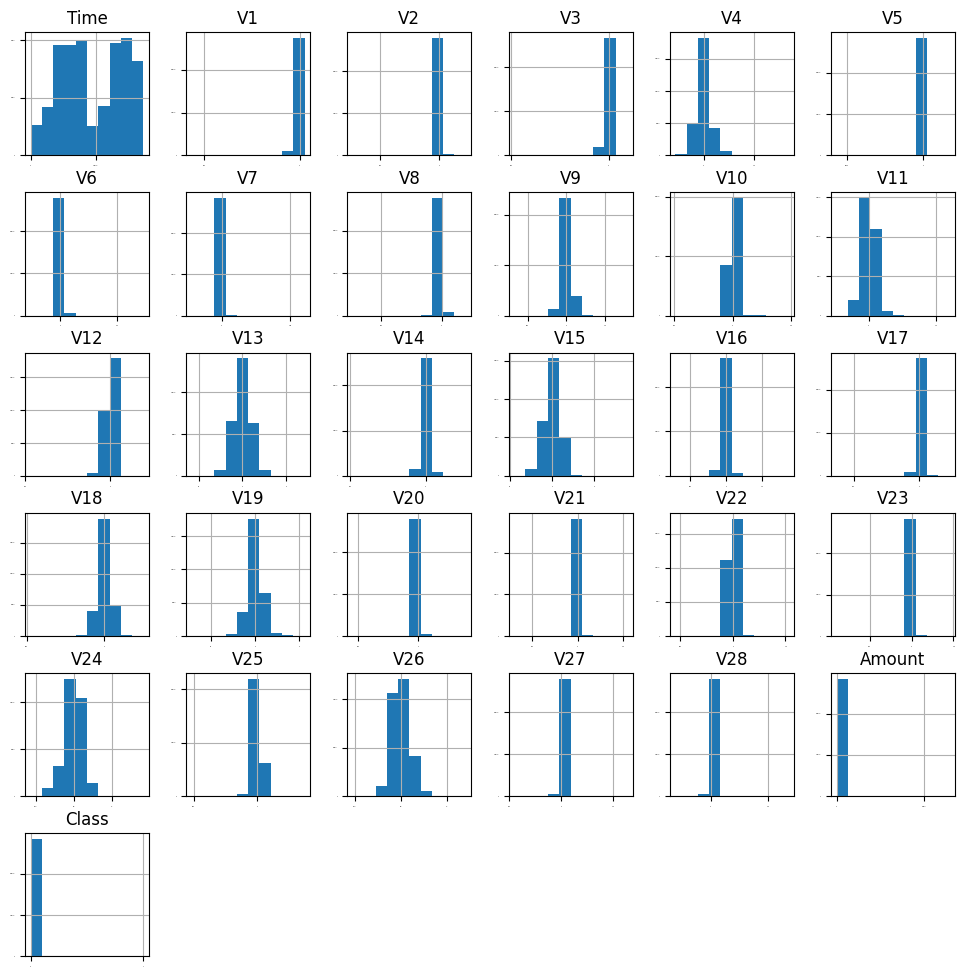

In [ ]:
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

Phân phối của hầu hết các biến đều bị lệch rất nhiều. Tuy nhiên, do cách đặt tên biến nên ta không thể có nhiều thông tin từ biểu đồ.

<a id='3'></a>
## Chuẩn bị dữ liệu

In [ ]:
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest( k=10) #dùng thư viện chọn ra 10 đặc trưng tốt nhất
bestfeatures
Y= dataset["Class"]
X = dataset.loc[:, dataset.columns != 'Class']
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(10,'Score'))

   Specs         Score
17   V17  33979.168593
14   V14  28695.547788
12   V12  20749.822361
10   V10  14057.979985
16   V16  11443.349428
3     V3  11014.508305
7     V7  10349.605408
11   V11   6999.355047
4     V4   5163.832114
18   V18   3584.380605


Một số đặc trưng dù là có liên quan, nhưng việc lựa chọn đặc trưng nào tốt lại không được ưu tiên.

<a id='4'></a>
# Đánh giá thuật toán và mô hình

Phân chia dữ liệu thành tập train và test, bao gồm thêm các thước đo đánh giá

In [ ]:
# Phân chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập validation.
Y= dataset["Class"]
X = dataset.loc[:, dataset.columns != 'Class']
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)
scoring = 'accuracy'

In [ ]:
df1 = pd.concat([X_validation, Y_validation], axis=1)
print(len(df1.loc[df1['Class'] == 1]))

100


Kiểm tra mô hình và thuật toán

In [ ]:
num_folds = 10
seed = 7

In [ ]:
# kiểm tra một số thuật toán cơ bản
# các thuật toán được comment lại là những thuật toán có tốc độ chậm
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))
# #Neural Network
# models.append(('NN', MLPClassifier()))
# # #Ensable Models
# # Boosting methods
# models.append(('AB', AdaBoostClassifier()))
# models.append(('GBM', GradientBoostingClassifier()))
# # Bagging methods
# models.append(('RF', RandomForestClassifier()))
# models.append(('ET', ExtraTreesClassifier()))

In [ ]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle = True, random_state=seed) #dữ liệu chia thành 10 phần bằng nhau để thực hiện cross-validation
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.998907 (0.000099)
LDA: 0.999350 (0.000149)
KNN: 0.998332 (0.000310)
CART: 0.999170 (0.000194)


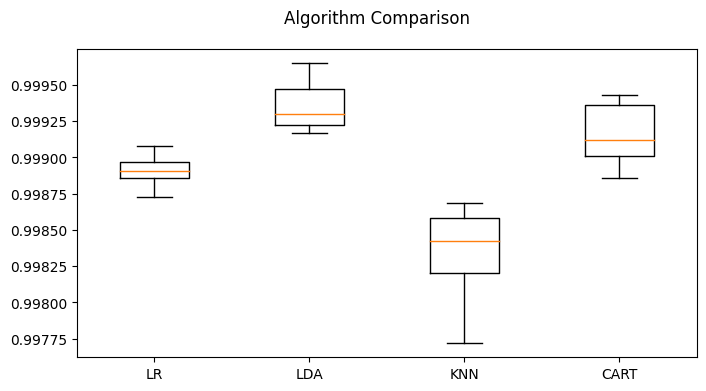

In [ ]:
# so sánh các thuật toán
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
pyplot.show()

Độ chính xác rất cao, vì nó tập trung vào TH không có gian lận tổng thể.

Nhưng hãy kiểm tra xem nó dự đoán TH gian lận như thế nào. Chọn mô hình CART từ các kết quả trên.

In [ ]:
# chuẩn bị mô hình decision tree (CART)
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

DecisionTreeClassifier()

In [ ]:
# ước tính độ chính xác trên tập validation
# rescaledValidationX = scaler.transform(X_validation)
rescaledValidationX = X_validation
predictions = model.predict(rescaledValidationX)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9992626663389628
[[56840    22]
 [   20    80]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.78      0.80      0.79       100

    accuracy                           1.00     56962
   macro avg       0.89      0.90      0.90     56962
weighted avg       1.00      1.00      1.00     56962



<Axes: xlabel='Predicted', ylabel='Actual'>

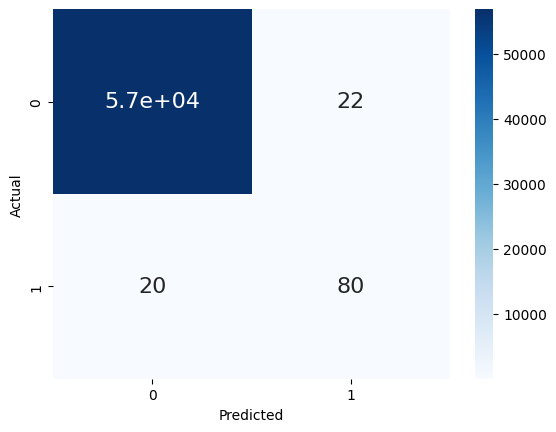

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

Mặc dù kết quả là tốt, nhưng vẫn có 19 trong số 100 gian lận không bị phát hiện. Vì vậy, chúng ta nên tập trung vào chỉ số recall, đây là một chỉ số giảm thiểu số lượng false negative.

# Điều chỉnh mô hình

## Điều chỉnh mô hình bằng cách chọn chỉ số đánh giá đúng
Chỉ số đánh giá được gọi là recall - một chỉ số giảm thiểu false negative.

In [ ]:
scoring = 'recall'

In [ ]:
# spot check some basic Classification algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))
# #Neural Network
# models.append(('NN', MLPClassifier()))
# # #Ensable Models
# # Boosting methods
# models.append(('AB', AdaBoostClassifier()))
# models.append(('GBM', GradientBoostingClassifier()))m,mms
# # Bagging methods
# models.append(('RF', RandomForestClassifier()))
# models.append(('ET', ExtraTreesClassifier()))

In [ ]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle = True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.657198 (0.054341)
LDA: 0.754710 (0.046704)
KNN: 0.033329 (0.028641)
CART: 0.742520 (0.051578)


In [ ]:
# Chuẩn bị mô hình LDA (Linear Discriminant Analysis)
model = LinearDiscriminantAnalysis()
model.fit(X_train, Y_train)

LinearDiscriminantAnalysis()

In [ ]:
# ước tính độ chính xác trên tập validation
# rescaledValidationX = scaler.transform(X_validation)
rescaledValidationX = X_validation
predictions = model.predict(rescaledValidationX)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9995435553526912
[[56854     8]
 [   18    82]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.91      0.82      0.86       100

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



<Axes: xlabel='Predicted', ylabel='Actual'>

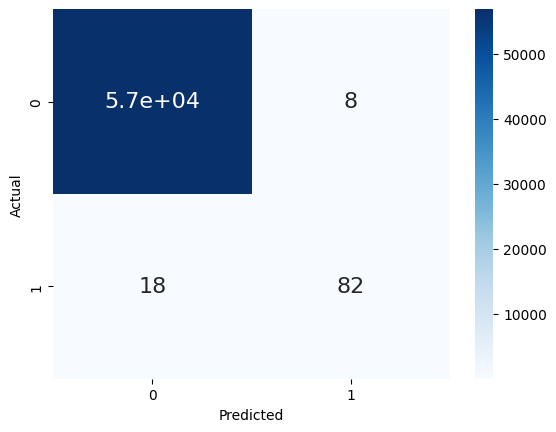

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

LDA hoạt động tốt hơn với chỉ 18 trường hợp gian lận không được phát hiện. Ngoài ra, số lượng false positives cũng ít hơn. Tuy nhiên, vẫn còn 18 trường hợp gian lận trong tập kiểm tra không được phát hiện. Điều này sẽ được xử lý thêm trong phần tiếp theo.

## Điều chỉnh mô hình để cân bằng mẫu bằng "Random Under Sampling"
Trong giai đoạn này của dự án, chúng ta sẽ thực hiện "Random Under Sampling", một phương pháp giảm mẫu ngẫu nhiên nhằm tạo ra một tập dữ liệu cân bằng hơn và tránh việc mô hình của chúng ta quá khớp.

Các bước:

1.   Điều đầu tiên chúng ta cần làm là xác định mức độ mất cân bằng của các lớp (sử dụng "value_counts()" trên cột lớp để xác định số lượng cho mỗi nhãn).
2.   Sau khi xác định số lượng giao dịch gian lận (Fraud = "1"), chúng ta sẽ đưa các giao dịch không gian lận về cùng số lượng giao dịch gian lận (giả sử chúng ta muốn tỷ lệ 50/50), điều này sẽ tương đương với 492 trường hợp gian lận và 492 trường hợp không gian lận.
3. Sau khi thực hiện kỹ thuật này, chúng ta có một phần con của khung dữ liệu của chúng ta với tỷ lệ 50/50 đối với các lớp của chúng ta. Sau đó, bước tiếp theo chúng ta sẽ thực hiện là xáo trộn dữ liệu để xem liệu mô hình của chúng ta có thể duy trì một độ chính xác nhất định mỗi khi chúng ta chạy script này hay không.

Lưu ý: Vấn đề chính với "Random Under-Sampling" là chúng ta đang chạy rủi ro là các mô hình phân loại của chúng ta sẽ không thực hiện chính xác như chúng ta muốn do có mất mát thông tin lớn (đưa 492 giao dịch không gian lận từ 284,315 giao dịch không gian lận).


In [ ]:
Y_train.head()

44828     0
221877    0
278826    0
149792    0
226041    0
Name: Class, dtype: int64

In [ ]:
df = pd.concat([X, Y], axis=1)
# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:1148]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
df_new = normal_distributed_df.sample(frac=1, random_state=42)
# split out validation dataset for the end
Y_train_new= df_new["Class"]
X_train_new = df_new.loc[:, dataset.columns != 'Class']

dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Distribution of the Classes in the subsample dataset
0    0.7
1    0.3
Name: Class, dtype: float64


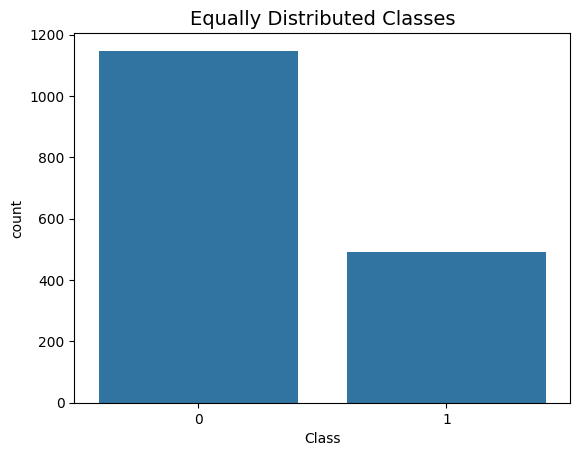

In [ ]:
print('Distribution of the Classes in the subsample dataset')
print(df_new['Class'].value_counts()/len(df_new))

sns.countplot(x='Class', data=df_new)
pyplot.title('Equally Distributed Classes', fontsize=14)
pyplot.show()

Bây giờ chúng ta đã có khung dữ liệu được cân bằng đúng cách, chúng ta có thể tiến xa hơn trong phân tích và tiền xử lý dữ liệu của chúng ta. Với tổng số điểm dữ liệu khoảng 900, chúng ta sẽ thử tất cả các mô hình bao gồm cả các mô hình Deep Learning. Tuy nhiên, với dữ liệu đã được cân bằng, chỉ số được sử dụng ở đây là độ chính xác, vì nó tập trung vào cả false positive và false negative.

In [ ]:
scoring='accuracy'

In [ ]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
# #Ensable Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

In [ ]:
# Viết phần phân loại Deep Learning trong trường hợp Deep Learning Flag được thiết lập thành True
# Đặt Flag sau thành 1 nếu muốn bật cờ Deep Learning Models

EnableDLModelsFlag = 1

if EnableDLModelsFlag == 1 :
    # Function to create model, required for KerasClassifier
    def create_model(neurons=12, activation='relu', learn_rate = 0.01, momentum=0):
        # tạo mô hình
        model = Sequential()
        model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation=activation))
        model.add(Dense(32, activation=activation))
        model.add(Dense(1, activation='sigmoid'))
        # cấu hình mô hình và chuẩn bị huấn luyện
        optimizer = SGD(lr=learn_rate, momentum=momentum)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    models.append(('DNN', KerasClassifier(build_fn=create_model, epochs=50, batch_size=10, verbose=0)))

In [ ]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle= True, random_state=seed)
    cv_results = cross_val_score(model, X_train_new, Y_train_new, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.996951 (0.004090)
LDA: 0.970122 (0.012026)
KNN: 0.998780 (0.002439)
CART: 0.998171 (0.002794)
NB: 0.997561 (0.004045)
SVM: 0.998171 (0.002794)
NN: 0.868293 (0.167748)
AB: 0.998780 (0.002439)
GBM: 0.998780 (0.002439)
RF: 0.998780 (0.002439)
ET: 0.997561 (0.005589)
6/6 [==============================] - 0s 2ms/step
DNN: 0.970122 (0.077631)


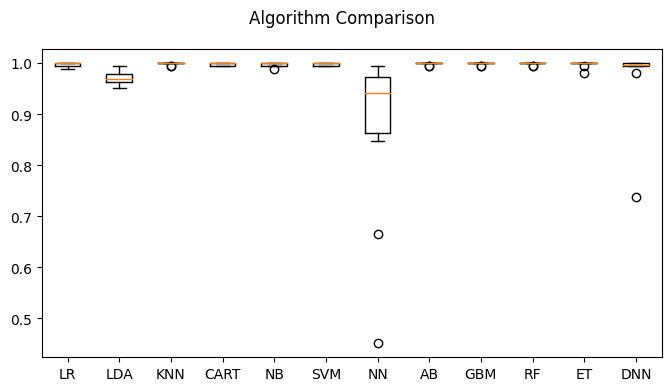

In [ ]:
# So sánh thuật toán
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
pyplot.show()

Vì GBM là mô hình tốt nhất trong tất cả các mô hình, ta thực hiện một tìm kiếm lưới (grid search) cho mô hình GBM bằng cách thay đổi số lượng bộ ước lượng (number of estimators) và độ sâu tối đa của cây (maximum depth).

In [ ]:
# Grid Search: GradientBoosting Tuning
'''
n_estimators : int (default=100)
    The number of boosting stages to perform.
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators.
    The maximum depth limits the number of nodes in the tree.
    Tune this parameter for best performance; the best value depends on the interaction of the input variables.

'''
n_estimators = [20,180,1000]
max_depth= [2, 3,5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train_new, Y_train_new)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.998780 using {'max_depth': 2, 'n_estimators': 20}
#1 0.998780 (0.002439) with: {'max_depth': 2, 'n_estimators': 20}
#1 0.998780 (0.002439) with: {'max_depth': 2, 'n_estimators': 180}
#1 0.998780 (0.002439) with: {'max_depth': 2, 'n_estimators': 1000}
#1 0.998780 (0.002439) with: {'max_depth': 3, 'n_estimators': 20}
#1 0.998780 (0.002439) with: {'max_depth': 3, 'n_estimators': 180}
#1 0.998780 (0.002439) with: {'max_depth': 3, 'n_estimators': 1000}
#9 0.998171 (0.003904) with: {'max_depth': 5, 'n_estimators': 20}
#1 0.998780 (0.002439) with: {'max_depth': 5, 'n_estimators': 180}
#1 0.998780 (0.002439) with: {'max_depth': 5, 'n_estimators': 1000}


In [ ]:
# chuẩn bị mô hình
model = GradientBoostingClassifier(max_depth= 5, n_estimators = 1000)
model.fit(X_train_new, Y_train_new)

GradientBoostingClassifier(max_depth=5, n_estimators=1000)

In [ ]:
# Ước lượng độ chính xác trên tập dữ liệu kiểm tra gốc
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.012552227800990134
[[  615 56247]
 [    0   100]]
              precision    recall  f1-score   support

           0       1.00      0.01      0.02     56862
           1       0.00      1.00      0.00       100

    accuracy                           0.01     56962
   macro avg       0.50      0.51      0.01     56962
weighted avg       1.00      0.01      0.02     56962



<Axes: xlabel='Predicted', ylabel='Actual'>

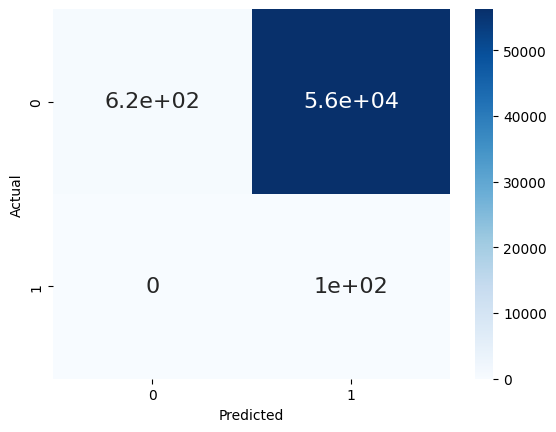

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

Kết quả trên tập dữ liệu kiểm tra rất tốt và mô hình hoạt động tốt hơn

__Kết luận__:

Việc lựa chọn chỉ số đúng đã dẫn đến sự cải thiện trong việc phát hiện các trường hợp gian lận một cách chính xác. Việc giảm mẫu đã dẫn đến một cải thiện đáng kể khi tất cả các trường hợp gian lận trong tập kiểm tra đều được xác định đúng sau khi giảm mẫu.

Tuy nhiên, việc giảm mẫu đến với một sự đánh đổi. Trong dữ liệu được giảm mẫu, mô hình của chúng tôi không thể phát hiện đúng cho một số lượng lớn các giao dịch không gian lận và thay vào đó, phân loại nhầm các giao dịch không gian lận đó là các trường hợp gian lận.